<br>

<br>
<br>
<br>

<br>
<h1 ><big><center>Probabilistic Graphical Models</center></big></h1>


<h2><big><center> HOMEWORK 2 </center></big></h2>

<h3><big><center> Bastien Batardiere </center></big></h3>
<h3><big><center> Omar Souaidi </center></big></h3>



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import time 
import scipy
from scipy.sparse.linalg import LinearOperator,bicg
import numpy.linalg
from scipy import stats
from PIL import Image

 <h3><big> Question 1 : Belief propagation  </h3></big> 

In [5]:
original_image = Image.open("/content/drive/MyDrive/spiral.png").resize((80,80))
# Convert image to grayscale
img = np.asarray(original_image).mean(axis=2)
# Rescale (binary image)
img = img / 255
img = img.astype(int)
height, width = img.shape

$\begin{align}
p(x) &= \frac{1}{Z} e^\left(\alpha \sum^n_{i=1} x_i + \beta \sum_{(i,j)\in E}\mathbb{1}(x_i=x_j) \right) \\ 
p(x) &= \frac{1}{Z} \prod_{i=1}^{n} \psi_i(x_i)  \prod_{(i,j)\in E }\psi_{i,j}(x_i,x_j)
\end{align}$
With :
$$\left\{\begin{matrix}
\psi_i(x_i) = e^\left(\alpha x_i\right)
\\ 
\psi_{i,j}(x_i,x_j) = e^\left( \beta \mathbb{1}(x_i=x_j) \right)
\end{matrix}\right.$$

The probability of $x_i$ given all the $y_i$ is the a sum of $p(x|y)$ over all variables except $x_i$:

$\begin{align}
p(x_i | y) &= \sum_{x \setminus x_i}p(x|y) \\
 \end{align}$ \\
Using Bayes' rules: \\
$\begin{align}
p(x_i | y) &\propto \sum_{x \setminus x_i}p(x)p(y|x) \\
 \end{align}$ \\
Using the fact that $y_j$ are independant and that $y_j$ given $x_j$ are in dependent of $x_k$ for k in $[1,n]\setminus j$ \\
$\begin{align}
p(x_i | y) &\propto \sum_{x \setminus x_i}p(x) \prod_{j=1}^n p(y_j|x_j) \\
p(x_i | y) &\propto \sum_{x \setminus x_i}p(x) \prod_{j=1}^n N(y_j|\mu_{x_j}, 1)
 \end{align}$

Using that : \\
$\begin{align} 
p(x) &= \frac{1}{Z} \prod_{i=1}^{n} \psi_i(x_i)  \prod_{(i,j)\in E }\psi_{i,j}(x_i,x_j) 
\end{align}$ 

we have then : \\
$$\begin{align*}
p(x_i | y) 
\propto  N(y_i|\mu_{x_i}, 1) \psi_i(x_i) \prod_{j\in ne(i)} \mu_{j->i} (x_i)
\end{align*}$$ 

Where :
$$\begin{align*}
\mu_{j->i} (x_i) = &= \sum_j \psi_{j, i}(x_j, x_i) \psi_j(x_j) N(y_j |\mu_{x_j}, 1) \prod_{k\in ne(j)\setminus \{i\}  } \mu_{k->j} (x_j)
\end{align*}$$

We can rewrite $\psi_j(x_j) N(y_j |\mu_{x_j}, 1)$ by $\psi_j(x_j,y_j)$ with : \\
$\psi_j(x_j,y_j) = e^{-\frac{(y_j - \mu_{x_j})^2}{2} +\alpha x_j}$


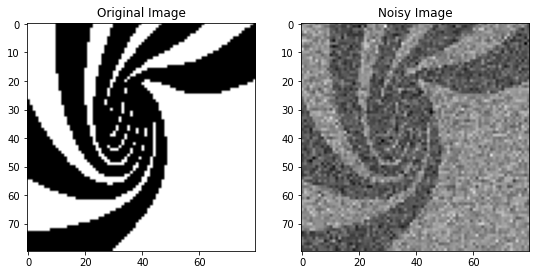

In [6]:
mu_0 = 0
mu_1 = 2.5
gaus_0 = np.random.normal(mu_0, 1, (height,width))
gaus_1 = np.random.normal(mu_1, 1, (height,width))
noisy_image = np.where(img>0.5, gaus_1, gaus_0)
fig, ax = plt.subplots(1,2,figsize = (9,5))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title("Original Image")
ax[1].imshow(noisy_image, cmap = 'gray')
ax[1].set_title("Noisy Image")
plt.show()

In [8]:
class Node:
  def __init__(self, idx):
    self.neighbors = []
    self.idx = idx
  
  def add_neighbors(self, neighbors):
    self.neighbors.append(neighbors)

class Graph:
  def __init__(self):
    self.nodes = []
  
  def generate_graph_from_image(self, image):
    # Creating nodes
    h, w = image.shape
    num_nodes = h*w
    self.generate_nodes(num_nodes)
    self.generate_neighbors(h, w)
  
  def generate_nodes(self, num_nodes):
    for i in range(num_nodes):
      self.nodes.append(Node(i))
  
  def generate_neighbors(self, height, width):
    for h in range(height):
      for w in range(width):
        idx = w + width*h
        if w < width - 1:
            self.nodes[idx].add_neighbors(self.nodes[idx+1])
        if w > 0:
            self.nodes[idx].add_neighbors(self.nodes[idx-1])        
        if h > 0:
            self.nodes[idx].add_neighbors(self.nodes[idx-width])
        if h < height - 1:
            self.nodes[idx].add_neighbors(self.nodes[idx+width])

beta = 0.1
alpha = 0.6

def psi_i(x,y) :
  return np.exp(alpha * x - (( y - mu_0 )**2)/2) if x==0 else np.exp(alpha * x - (( y - mu_1 )**2)/2)

def psi_ij(xi,xj):
  return np.exp(beta) if xi == xj else 1


class LoopyBelief:
  def __init__(self, noisy_image):
    self.H, self.W = noisy_image.shape
    self.noisy_image = noisy_image
  
  def noisy_belief(self):
    graph = Graph()
    h, w = self.H, self.W
    img_denoised = np.zeros((h,w))
    graph.generate_graph_from_image(self.noisy_image)

    ## Initialisation des mesgaes
    message_grid = np.zeros((h*w,h*w,2))
    for node in graph.nodes:
      for neighbor in node.neighbors:
          message_grid[node.idx][neighbor.idx][0] = np.random.uniform() 
          message_grid[node.idx][neighbor.idx][1] = np.random.uniform() 
    
    updated_message_grid = np.zeros((h*w,h*w,2))
    for node in graph.nodes:
      for neighbor in node.neighbors:
        j, i = node.idx, neighbor.idx
        updated_message_grid[j][i][0]  = self.compute_message(node, 0, message_grid)
        updated_message_grid[j][i][1]  = self.compute_message(node, 1, message_grid)

    # We compute p(xi=0|y) and if 0.5 > p(xi=0|y) we set the value to 1, otherwise to 0.
    for node in graph.nodes:
      j = node.idx
      p0  = psi_i(0,noisy_image[j//w][j%w])
      p1 = psi_i(1,noisy_image[j//w][j%w])
      
      for neighbor in node.neighbors : 
          p0 *= updated_message_grid[neighbor.idx][j][0]
          p1 *= updated_message_grid[neighbor.idx][j][1]
  
      p0= p0 /(p0+p1)
      if 0.5 > p0 :
          img_denoised[j//w][j%w] =1
      else :
          img_denoised[j//w][j%w] =0
    return img_denoised
    
  def compute_message(self, node, value, grid):
      message = 0
      idx = node.idx
      for x in [0,1]:
        y = self.noisy_image[idx//self.W][idx%self.W]
        partial_message = psi_ij(x, value) * psi_i(x, y)
        for neighbor in node.neighbors:
          if neighbor.idx == idx:
            continue
          partial_message *= grid[neighbor.idx][idx][0] * grid[neighbor.idx][idx][1]
        message += partial_message
      return message

In [9]:
alg = LoopyBelief(noisy_image)

In [10]:
output = alg.noisy_belief()

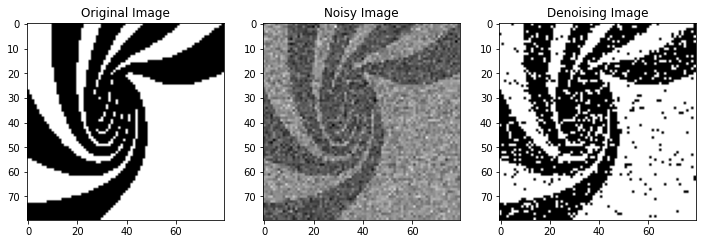

In [11]:
fig, ax = plt.subplots(1,3,figsize = (12,12))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title("Original Image")
ax[1].imshow(noisy_image, cmap = 'gray')
ax[1].set_title("Noisy Image")
ax[2].imshow(output, cmap = 'gray')
ax[2].set_title("Denoising Image")
plt.show()

<h3><big> Réponse aux questions </h3></big>

Les réponses sont données en pdf dans le fichier 'Réponses_question_2_a_5'.

Les fichiers H.mat et x.mat sont également disponibles dans le dossier. 


In [14]:
H = loadmat("/content/drive/MyDrive/H.mat")['H']
x = loadmat("/content/drive/MyDrive/x.mat")['x']
x_2D = x.reshape((90,90))#,order = 'F')
x_2D = (x_2D<0.3)*1
cmap ='gray'


In [15]:
# On definit ici les parametres
mu_0 = 1
mu_1 = 5
intensity_noise = 1
height = np.shape(x_2D)[0]-1 # mal défini car il y a 
length = np.shape(x_2D)[1]-1
alpha = 0.5 
beta = 1
a = 1
b = 2 
m = 1
s2 = 1 

Voici l image de départ :


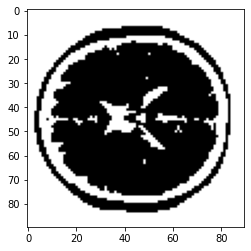

Voici notre image bruitee : 


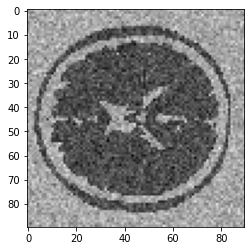

In [16]:
def mu(x,mu_0,mu_1): 
    if x == 0: 
        return mu_0
    if x ==1 :
        return mu_1
    print('pb x n est pas 0 ou 1')
    return None 

# construit y en deux dimensions a partir d'un vecteur d'une seule dimension     
def construct_y(x_2D,intensity,mu_0,mu_1):
    y_2D = np.zeros(x_2D.shape)
    for i in range(x_2D.shape[0]):
        for j in range(x_2D.shape[1]):
            y_2D[i,j]= mu(x_2D[i,j],mu_0,mu_1)+intensity*np.random.randn()
    return y_2D


y_2D = construct_y(x_2D,intensity_noise,mu_0,mu_1)
print('Voici l image de départ :')
plt.imshow(x_2D,cmap = cmap)
plt.show()
print('Voici notre image bruitee : ')
plt.imshow(y_2D,cmap = cmap)
plt.show()

In [17]:
# hauteur et longeur du graphe
height = np.shape(x_2D)[0]-1 # mal défini car il y a 
length = np.shape(x_2D)[1]-1


On définit dabord des classes pour plus de clarté.

In [18]:
# calcule les coordonnees d'un voisin 
def coord_voisins(coord):
    x = coord[0]
    y = coord[1]
    # on fait tous les cas possibles
    if x == 0 and y == 0 :
        return np.array([[1,0],[0,1]])
    if x == length and y == 0 :
        return np.array([[length-1,0],[length,1]])
    if x == length and y == height :
        return np.array([[length-1,height],[length,height-1]])
    if x == 0 and y == height :
        return np.array([[0,height-1],[1,height]])
    if x ==0 : 
        return np.array([[0,y+1],[0,y-1],[1,y]])
    if y == 0 : 
        return np.array([[x-1,0],[x+1,0],[x,1]])
    if x == length : 
        return np.array([[x,y-1],[x,y+1],[x-1,y]])
    if y == height :
        return np.array([[x-1,y],[x+1,y],[x,y-1]])
    return np.array([[x,y+1],[x+1,y],[x-1,y],[x,y-1]])
# calcule le noeud suivant
#le suivant est le voisin du dessus, sauf si il n'existe pas. Dans ce cas on revient en bas en augmentant l'abscisse de 1 ou bien on retourne au départ
def suivant(coord): 
    x = coord[0]
    y = coord[1]
    if y == height and x == length : 
        return np.array([0,0])
    if y == height: 
        return np.array([x+1,0])
    return np.array([x,y+1])        

In [19]:
# definition d'une classe noeud 
class Noeud: 
    
    def __init__(self,valeur,ab,ordo,estim = None):
        self.valeur = valeur # valeur du point 
        self.ab = ab  # ab comme abscisse
        self.ordo = ordo # ordo comme ordonnee 
        self.coord_voisins = coord_voisins(np.array([ab,ordo]))
        self.estim = estim 
    def change(self,new_value):
        self.valeur = new_value
    def display(self): 
        print(' coord :', self.ab,self.ordo, 'estim :', self.estim, 'valeur :', self.valeur)
        print('\n')

In [20]:
# definition d'une classe graphe. Un graphe est une matrice de Noeuds
class Graphe : 
    def __init__(self, x_2D, y_2D, mu_0 =mu_0, mu_1 = mu_1, alpha = alpha, beta = beta,random_init_mu = False,random_init_prior = False):
        self.mat = []
        for i in range(x_2D.shape[0]):
            list_Noeud = []
            for j in range(x_2D.shape[1]): 
                    list_Noeud.append(Noeud(x_2D[i,j], i, j, estim = y_2D[i,j]))
            self.mat.append(list_Noeud)
                    
        self.height = x_2D.shape[0]-1 # moins 1 our avoir une liste coherene ( commence a 0 et finit a longueur -1 )
        self.length = x_2D.shape[1]-1 # moins 1 our avoir une liste coherente
        self.mu_0 = mu_0
        self.mu_1 = mu_1 
        self.alpha = alpha
        self.beta = beta
        if random_init_mu : 
            self.mu_0 = m + np.sqrt(s2)*np.random.randn() # we add some noise if we want to infer mu
            self.mu_1 = m +3+ np.sqrt(s2)*np.random.randn() # add some noise 
        if random_init_prior : 
            self.alpha = a*np.random.rand()
            self.beta = b*np.random.rand()
            
    def get_noeud(self,coord):
        return self.mat[coord[0]][coord[1]]
    def get(self,i,j):
        return self.mat[i][j].valeur
    def suivant(self, current_node): 
        suiv = suivant(np.array([current_node.ab,current_node.ordo]))
        next_noeud = self.get_noeud(np.array([suiv[0],suiv[1]]))
        return next_noeud
    def change_noeud(self,coord,new_valeur): 
        self.get_noeud(coord).change(new_valeur)
    def set_mu_0(self,mu): 
        self.mu_0 = mu
    def set_mu_1(self,mu): 
        self.mu_1 = mu
    def set_alpha(self,alpha):
        self.alpha = alpha
    def set_beta(self,beta):
        self.beta = beta 
    def get_voisins(self,noeud):
        list_Noeud = []
        list_coord = noeud.coord_voisins
        for coord in list_coord : 
            list_Noeud.append(self.get_noeud(coord))
        return list_Noeud
    def display_noeud(self,noeud):
        display(noeud)
    def display_voisins(self,noeud):
        for vois in self.get_voisins(noeud):
            vois.display()
    def get_x_2D(self):
        output = np.zeros((self.length+1,self.height+1))
        for i in range (self.length+1):
            for j in range(self.height+1): 
                output[i,j]= self.get(i,j)
        return output

In [21]:
# permet d'afficher un graphe 
def display_graphe(graphe):
        output = graphe.get_x_2D()
        plt.imshow(output,cmap = cmap)
        plt.show()
        

<h3><big> Question 2 :Gibbs Sampling </big></h3>

In [22]:
def dirac(x,y):
    if x==y : 
        return 1 
    return 0 

In [23]:
# calcule la densité a une constante multiplicative pres
def p_xi_given_xmi(graphe, coord,x_i):
    noeud = graphe.get_noeud(coord)
    voisins = graphe.get_voisins(noeud)
    ins = graphe.alpha*x_i
    ins += graphe.beta*np.sum(np.array([dirac(x_i,vois.valeur) for vois in voisins]))
    ins -= 1/2*(noeud.estim-mu(x_i,graphe.mu_0,graphe.mu_1))**2
    return np.exp(ins)

# calcule la densité normalisée 
def dens_xi_given_xmi(graphe,coord,x_i):
    normalisation = p_xi_given_xmi(graphe, coord,1)+p_xi_given_xmi(graphe, coord,0)
    return p_xi_given_xmi(graphe, coord,x_i)/normalisation



In [24]:
# MCMC algorithme
def Gibbs_sampling(graphe):
    current_node = graphe.get_noeud(np.array([0,0]))
    for i in range(graphe.length):
        for j in range(graphe.height):
            acceptance = dens_xi_given_xmi(graphe,np.array([i,j]),1)
            u = np.random.rand()
            if u < acceptance : 
                graphe.change_noeud(np.array([i,j]),1)
            else : 
                graphe.change_noeud(np.array([i,j]),0)
            current_node = graphe.suivant(current_node)
            



Voici l image au départ :


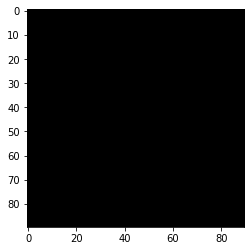

Voici l image apres gibbs sampling :


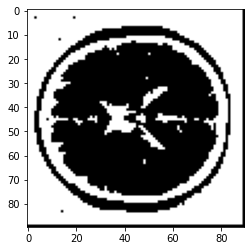

In [25]:
y_first = construct_y(x_2D,0.5,mu_0,mu_1)
test_graphe = Graphe(np.zeros(x_2D.shape),y_first)
print('Voici l image au départ :')
display_graphe(test_graphe)
Gibbs_sampling(test_graphe)
print('Voici l image apres gibbs sampling :')
display_graphe(test_graphe)


<h3><big> QUESTION 3 : EM Algorithme </h3></big>

In [30]:
# calcule mu chapeau pour l'EM 
def compute_probs(graphe):
    longueur = graphe.height*graphe.length
    prob_mu_1 = 0
    prob_mu_0 = 0
    norm_mu_0 = 0
    norm_mu_1 = 0
    current_node = graphe.get_noeud(np.array([0,0]))
    for j in range(longueur): 
        density_1 = dens_xi_given_xmi(graphe,np.array([current_node.ab,current_node.ordo]),1)
        prob_mu_1 += density_1*current_node.estim
        norm_mu_1+=density_1
        density_0 = 1-density_1
        prob_mu_0 += density_0*current_node.estim
        norm_mu_0+= density_0
        current_node = graphe.suivant(current_node)
    return prob_mu_0/(norm_mu_0+1e-8),prob_mu_1/(norm_mu_1+1e-8)

# effectue un tour de Gibbs sampling en adaptant les paraetres mu_0 et mu_1
def one_step_mu(graphe,mu_0_init,mu_1_init):
    graphe.set_mu_0(mu_0_init)
    graphe.set_mu_1(mu_1_init)
    Gibbs_sampling(graphe)
    new_mu_0,new_mu_1 = compute_probs(graphe)
    return new_mu_0,new_mu_1

# estime mu avec un nombre d'iterations choisi
def infer_mu(graphe,Niter = 5):
    mu_0_init = graphe.mu_0
    mu_1_init = graphe.mu_1
    print('Voici la vraie valeur de mu_0 :', mu_0)
    print('Voici la vraie valeur de mu_1 :', mu_1)
    print('Voici mu_0 au début : ', round(mu_0_init,6))
    print('Voici mu_1 au début : ', round(mu_1_init,6))
    for i in range(Niter): 
        mu_0_infer,mu_1_infer = one_step_mu(graphe,mu_0_init,mu_1_init)
        mu_0_init,mu_1_init = mu_0_infer,mu_1_infer
        display_graphe(graphe)
        print('UPDATE DES PARAMETRES')
        print('mu_0 :',round(graphe.mu_0,6))
        print('mu_1 :',round(graphe.mu_1,6))
    graphe.set_mu_0(mu_0_infer)
    graphe.set_mu_1(mu_1_infer)
    return graphe 

Voici la vraie valeur de mu_0 : 1
Voici la vraie valeur de mu_1 : 5
Voici mu_0 au début :  -1.245674
Voici mu_1 au début :  3.15832


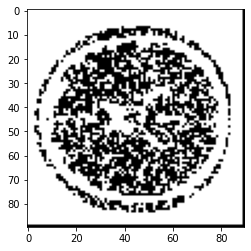

UPDATE DES PARAMETRES
mu_0 : -1.245674
mu_1 : 3.15832


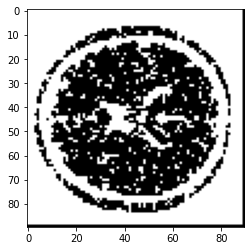

UPDATE DES PARAMETRES
mu_0 : 0.335696
mu_1 : 3.936673


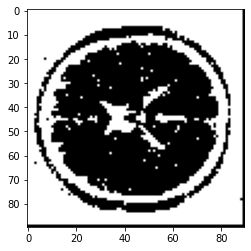

UPDATE DES PARAMETRES
mu_0 : 0.840144
mu_1 : 4.756701


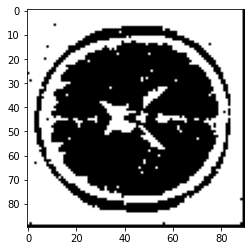

UPDATE DES PARAMETRES
mu_0 : 0.974148
mu_1 : 4.979903


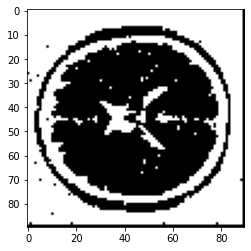

UPDATE DES PARAMETRES
mu_0 : 0.989355
mu_1 : 4.99926


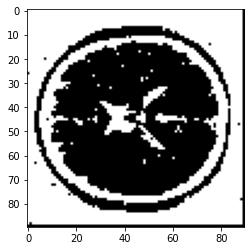

UPDATE DES PARAMETRES
mu_0 : 0.992287
mu_1 : 5.002566


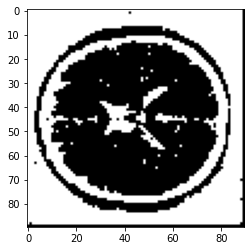

UPDATE DES PARAMETRES
mu_0 : 0.992776
mu_1 : 5.002988


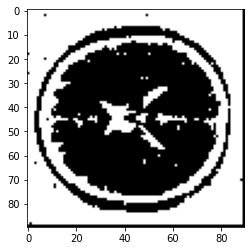

UPDATE DES PARAMETRES
mu_0 : 0.992619
mu_1 : 5.002613
Image trouvee :


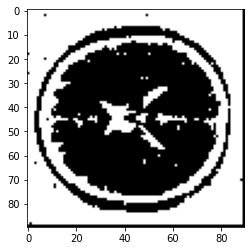

 Reelle image :
 Erreur d estimation de mu_0 : 0.007308  Erreur d estimation de mu_1 : 0.002586


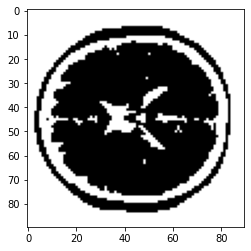

In [36]:
graphe_infer = Graphe(np.zeros(y_2D.shape),y_2D,random_init_mu = True)
graphe_infer = infer_mu(graphe_infer,Niter = 8)
print('Image trouvee :')
display_graphe(graphe_infer)
print(' Reelle image :')
print(' Erreur d estimation de mu_0 :', round(np.abs(graphe_infer.mu_0-mu_0),6),' Erreur d estimation de mu_1 :', round(np.abs(graphe_infer.mu_1-mu_1),6))
plt.imshow(x_2D,cmap = cmap)
plt.show()

<h3><big> QUESTION 5 : Extended MCMC </h3></big>

In [37]:
# simule x,alpha,beta,mu_0,mu_1
def extend_MCMC(y,Niter):
    random_graphe = Graphe(np.zeros(y.shape),y,random_init_mu = True, random_init_prior = True) # we initialize randomly the parameters mu, alpha and beta
    for i in range(Niter): 
        Gibbs_sampling(random_graphe)
        print('alpha = ', round(random_graphe.alpha,6), 'beta =',round(random_graphe.beta,6),'mu_0 = ', round(random_graphe.mu_0,3), 'mu_1 =', round(random_graphe.mu_1,3))
        display_graphe(random_graphe)
        random_graphe.set_mu_0(m + np.sqrt(s2)*np.random.randn())
        random_graphe.set_mu_1(m + np.sqrt(s2)*np.random.randn())
        random_graphe.set_alpha(a*np.random.rand())
        random_graphe.set_beta(b*np.random.rand())


alpha =  0.803369 beta = 0.845067 mu_0 =  1.275 mu_1 = 4.962


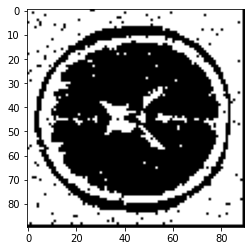

alpha =  0.926448 beta = 1.651593 mu_0 =  1.834 mu_1 = 0.277


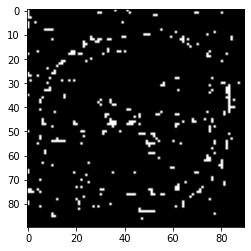

alpha =  0.114652 beta = 0.202866 mu_0 =  1.273 mu_1 = 0.938


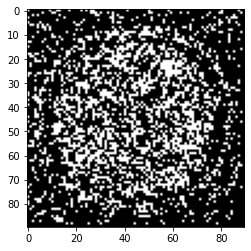

alpha =  0.904164 beta = 0.495262 mu_0 =  3.286 mu_1 = 1.592


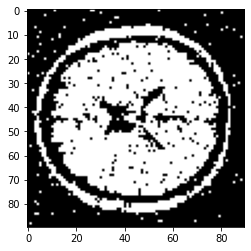

alpha =  0.122943 beta = 1.082966 mu_0 =  0.955 mu_1 = 0.375


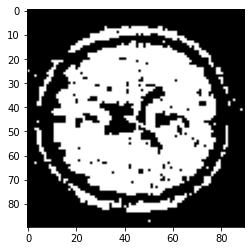

alpha =  0.385323 beta = 1.817341 mu_0 =  0.823 mu_1 = 0.905


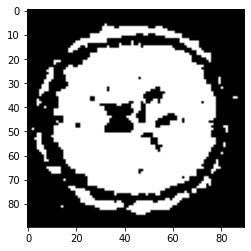

alpha =  0.465098 beta = 0.332483 mu_0 =  1.513 mu_1 = 1.888


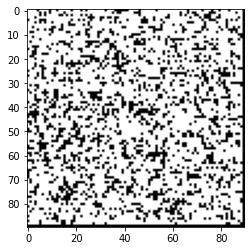

In [38]:
extend_MCMC(y_2D,7)